## Содержание

[Библиотеки](#libraries)

[1. Анализ выборки](#data_analysis)

[2. Подготовка обучающей и тестовой выборок](#train_test_data_prep)

[3. Классификатор ракурса](#view_classifier)
* [Подготовка данных](#data_prep)
* [Тест модели](#model_test)
* [Обучение модели](#model_train)

<a id='libraries'></a>
## Библиотеки

In [1]:
import os

from dataset import sampling
from dataset import indexing
from dataset import preprocess_hist as prepr_hst

import dataset.custom_datasets as cust_ds
import dataset.default_augmentations as def_augs
import dataset.classif_dataset_test as cl_ds_test

from models.triplet_loss import ClassificationForTLModel
import model_test.classify_model_test as class_m_test
from model_selection.metrics import CustomAccuracy, F1Score

<a id='data_analysis'></a>
## 1. Анализ выборки

Почти все изображения визуально легко различить на ракурсы: "спереди", "сзади". Это можно использовать для того, чтобы разгрузить TL модели, избавив их от необходимости обобщаться на различные ракурсы изображений одних и тех же объектов. Можно обучить классификатор ракурса и с учетом его ответа отбирать для классификации с помощью Triplet Loss модели только признаки изображений соответсвующего ракурса. Сами Triplet Loss модели также необходимо переобучать - дополнительно по каждой на ракурс.

In [2]:
init_dataset_path = 'G:\\diplom\\project\\triplet_loss_project_2_06.04\\data\\015_model_marka_year_train'

In [3]:
folders = os.listdir(init_dataset_path)
indexes = indexing.get_indexes(folders)

Оценим распределение изображений по ракурсам

In [4]:
def view_indx_f(x):
    return x[2]

In [5]:
unique_data = prepr_hst.get_unique(indexes, view_indx_f)
view_t_indxs, view_uniqie, veiw_code_in = unique_data

In [6]:
view_hist_data = prepr_hst.get_hist_data(init_dataset_path, folders,
                                         view_t_indxs, veiw_code_in)

  0%|          | 0/6151 [00:00<?, ?it/s]

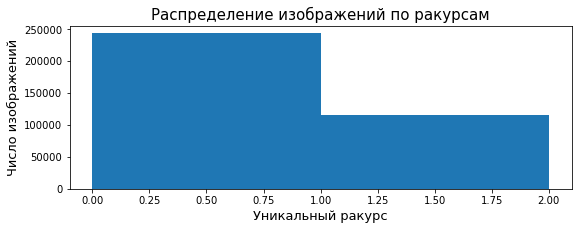

normal: 0 | 242799
back: 1 | 116055


In [7]:
title = 'Распределение изображений по ракурсам'
xlabel = 'Уникальный ракурс'
prepr_hst.plot_hist(view_hist_data, view_uniqie, title, xlabel)

for k, v in veiw_code_in.items():
    cnt = view_hist_data.count(v)
    print(f'{k}: {v} | {cnt}')

Изображений с ракурсом "спереди" примерно в $2,5$ раза больше, чем с ракурсом "сзади". Учитывая общее количество изображений в задаче бинарной классификации, это не столь сильная неравномерность распределения. Даже если просто отбросить $150$ тысяч изображений с ракурсом "спереди", чтобы уравнять выборки, с учетом аугментаций в процессе обучения число изображений приумножится более чем в $3$ раза, если давать возмутительно грубую оценку.

При обучении бинарного классификатора ракурса не должно возникнуть проблем в виду того, что визуально достаточно просто отличить один ракурс от другого, к тому же опять же обучающая выборка весьма объемная.

<a id='train_test_data_prep'></a>
## 2. Подготовка обучающей и тестовой выборок

In [8]:
datasets_path = 'G:\\diplom\\project\\triplet_loss_project_2_06.04\\data'
init_dataset_path = os.path.join(datasets_path, '015_model_marka_year_train')

**Обучающая выборка**

In [ ]:
output_folder_name = 'sampled_train_view'
_ = sampling.sample_data(init_dataset_path, datasets_path,
                         view_indx_f, output_folder_name,
                         min_th=0, max_th=116055, random_state=0)

**Тестовая выборка**

Положим, что по 10 тысяч изображений каждого класса будет достаточно для оценки точности работы классификатора. Это примеро $0,087$ процента от общего объема изображений.

In [ ]:
train_dataset_path = os.path.join(datasets_path, 'sampled_train_view')
_ = sampling.get_test_ds_from_train(train_dataset_path, 0.087,
                                    datasets_path, 'sampled_test_view',
                                    random_state=0)

**Перепроверка выборок**

In [10]:
train_dataset_path = os.path.join(datasets_path, 'sampled_train_view')
test_dataset_path = os.path.join(datasets_path, 'sampled_test_view')

  0%|          | 0/6124 [00:00<?, ?it/s]

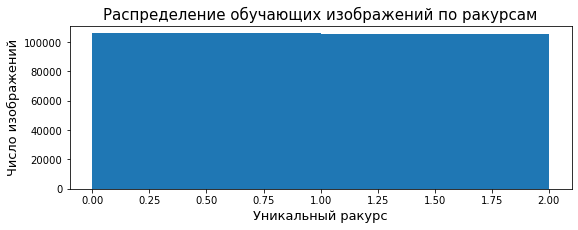

normal: 0 | 105838
back: 1 | 105528


In [11]:
folders_train = os.listdir(train_dataset_path)
indexes_train = indexing.get_indexes(folders_train)

unique_data_tr = prepr_hst.get_unique(indexes_train, view_indx_f)
view_t_indxs_tr, view_uniqie_tr, veiw_code_in_tr = unique_data_tr

view_hist_data_train = prepr_hst.get_hist_data(train_dataset_path,
                                               folders_train,
                                               view_t_indxs_tr,
                                               veiw_code_in_tr)

title_tr = 'Распределение обучающих изображений по ракурсам'
xlabel = 'Уникальный ракурс'
prepr_hst.plot_hist(view_hist_data_train, view_uniqie_tr, title_tr, xlabel)

for k, v in veiw_code_in_tr.items():
    cnt = view_hist_data_train.count(v)
    print(f'{k}: {v} | {cnt}')

  0%|          | 0/4865 [00:00<?, ?it/s]

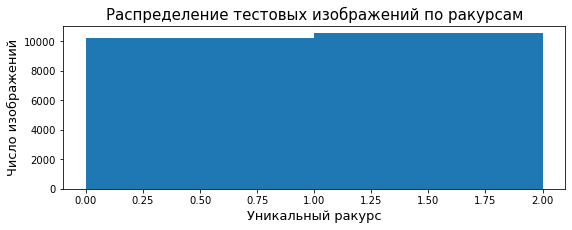

normal: 0 | 10217
back: 1 | 10527


In [12]:
folders_test = os.listdir(test_dataset_path)
indexes_test = indexing.get_indexes(folders_test)

unique_data_ts = prepr_hst.get_unique(indexes_test, view_indx_f)
view_t_indxs_ts, view_uniqie_ts, veiw_code_in_ts = unique_data_ts

view_hist_data_test = prepr_hst.get_hist_data(test_dataset_path,
                                              folders_test,
                                              view_t_indxs_ts,
                                              veiw_code_in_ts)

title_ts = 'Распределение тестовых изображений по ракурсам'
xlabel = 'Уникальный ракурс'
prepr_hst.plot_hist(view_hist_data_test, view_uniqie_ts, title_ts, xlabel)

for k, v in veiw_code_in_ts.items():
    cnt = view_hist_data_test.count(v)
    print(f'{k}: {v} | {cnt}')

<a id='view_classifier'></a>
## 3. Классификатор ракурса

<a id='data_prep'></a>
**Подготовка данных**

In [13]:
datasets_path = 'G:\\diplom\\project\\triplet_loss_project_2_06.04\\data'
train_ds_path = os.path.join(datasets_path, 'sampled_train_view')
test_ds_path = os.path.join(datasets_path, 'sampled_test_view')

In [14]:
classif_ds_train = cust_ds.TLClassifyDataset(
    train_ds_path, view_indx_f, crop=False,
    transform=def_augs.clTL_train_augs_128
)

classif_ds_test = cust_ds.TLClassifyDataset(
    test_ds_path, view_indx_f, crop=False,
    transform=def_augs.clTL_test_augs_128
)

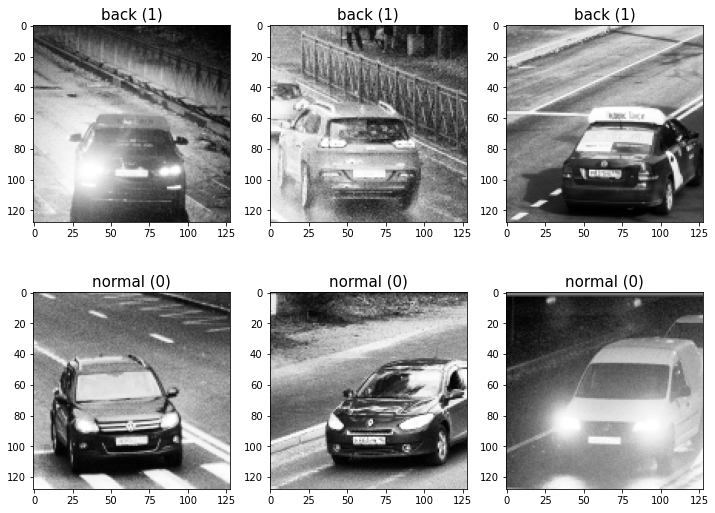

In [15]:
cl_ds_test.classify_ds_test(classif_ds_test, n_rows=2,
                            lines_span=1.5, figsize_sq=3)

<a id='model_test'></a>
**Тест модели**

In [16]:
view_classes_n = len(classif_ds_train.labels_code)
class_view_model = ClassificationForTLModel(view_classes_n)

Визуальный:

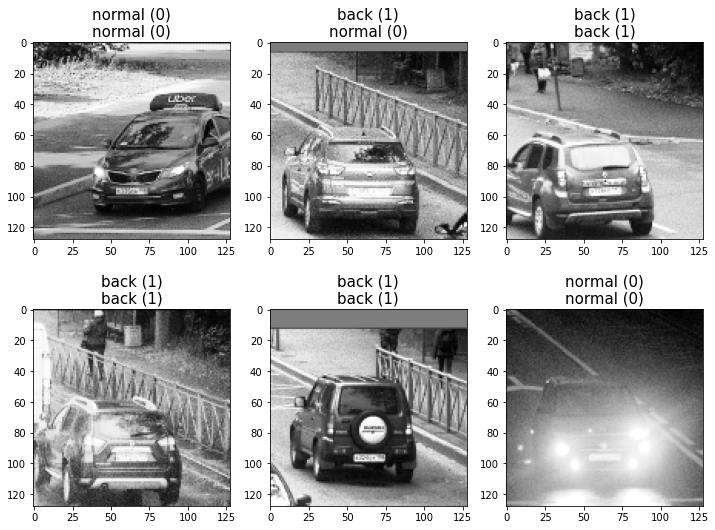

In [17]:
n_rows = 2

t = class_m_test.test_classif_model(class_view_model,
                                    classif_ds_test,
                                    n_rows=n_rows)

cl_ds_test.classify_ds_test(classif_ds_test, n_rows=n_rows,
                            lines_span=1.5, figsize_sq=3,
                            imgs_indexes=t[0], add_to_title=t[1])

Accuracy:

In [18]:
acc = CustomAccuracy()

In [19]:
acc_bef_learn = acc.ds_scope(classif_ds_test, class_view_model)

  0%|          | 0/649 [00:00<?, ?it/s]

In [20]:
print(f'Accuracy модели до обучения: {round(acc_bef_learn, 3)}')

Accuracy модели до обучения: 0.493


f1 score:

In [24]:
f1_score = F1Score()

In [25]:
f1_score_bef_learn = f1_score.ds_scope(classif_ds_test, class_view_model)

  0%|          | 0/649 [00:00<?, ?it/s]

In [26]:
print(f'f1 score модели до обучения: {round(f1_score_bef_learn, 3)}')

f1 score модели до обучения: 0.325


<a id='model_train'></a>
**Обучение модели**

In [27]:
weights_p = 'weights/5. view classifier/classif_model_weights_maxAccuracy.pt'
class_view_model.load_state(weights_p)

Визуальный тест обученной модели:

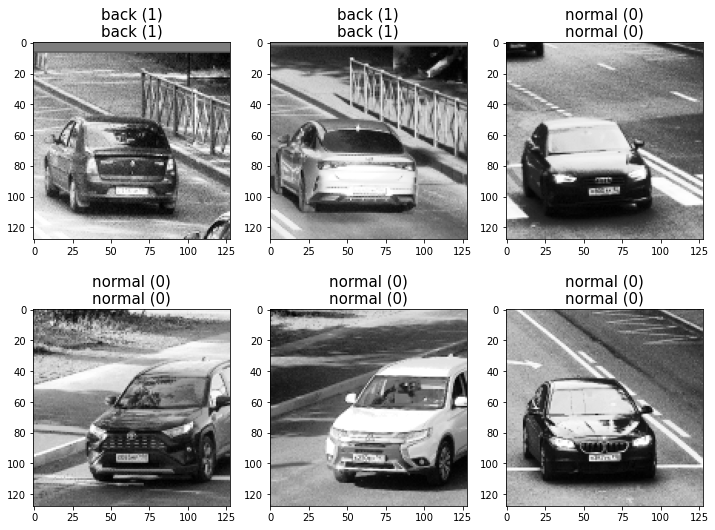

In [28]:
n_rows = 2

t = class_m_test.test_classif_model(class_view_model,
                                    classif_ds_test,
                                    n_rows=n_rows)

cl_ds_test.classify_ds_test(classif_ds_test, n_rows=n_rows,
                            lines_span=1.5, figsize_sq=3,
                            imgs_indexes=t[0], add_to_title=t[1])

Accuracy:

In [29]:
acc = CustomAccuracy()

In [30]:
acc_aft_learn = acc.ds_scope(classif_ds_test, class_view_model)

  0%|          | 0/649 [00:00<?, ?it/s]

In [31]:
print(f'Accuracy модели после обучения: {round(acc_aft_learn, 3)}')

Accuracy модели после обучения: 0.991


f1 score:

In [32]:
f1_score = F1Score()

In [33]:
f1_score_aft_learn = f1_score.ds_scope(classif_ds_test, class_view_model)

  0%|          | 0/649 [00:00<?, ?it/s]

In [34]:
print(f'f1 score модели после обучения: {round(f1_score_aft_learn, 3)}')

f1 score модели после обучения: 0.991
